[Reference](https://medium.com/@francescofranco_39234/conditional-generative-adversarial-networks-cgans-with-tensorflow-and-keras-e6b2476d6f34)

1/1 [==============================] - 0s 180ms/step


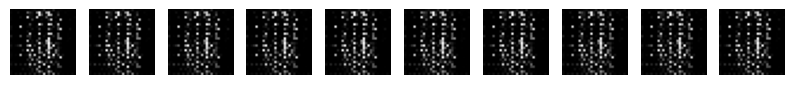

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt

(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)  # Convert labels to one-hot vectors

def build_discriminator():
    image_input = layers.Input(shape=(28, 28))
    label_input = layers.Input(shape=(10,))

    x = layers.Flatten()(image_input)
    x = layers.Concatenate()([x, label_input])
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=[image_input, label_input], outputs=x)
    return model

def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(10,))

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(7 * 7 * 256, activation='relu')(x)
    x = layers.Reshape((7, 7, 256))(x)
    x = layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu')(x)
    x = layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh')(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=x)
    return model

def discriminator_loss(real_output, fake_output):
    real_loss = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output), real_output)
    fake_loss = losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output), fake_output)
    return loss

discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

generator = build_generator()
discriminator = build_discriminator()

generator.compile(optimizer=generator_optimizer, loss=generator_loss)
discriminator.compile(optimizer=discriminator_optimizer, loss=discriminator_loss)

EPOCHS = 50
BATCH_SIZE = 128

for epoch in range(EPOCHS):
    for i in range(len(train_images) // BATCH_SIZE):
        images_batch = train_images[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        labels_batch = train_labels[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        train_step(images_batch, labels_batch)

    # Generate images at the end of each epoch
    noise = tf.random.normal([10, 100])
    labels = tf.one_hot(range(10), 10)
    generated_images = generator.predict([noise, labels])

    # Display the generated images
    fig = plt.figure(figsize=(10, 1))
    for j in range(10):
        plt.subplot(1, 10, j+1)
        plt.imshow(generated_images[j, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()